# Cell Types Project Group 9
*Replace this with the name of your project*

## Team Member Names & Contributions
*Feel free to name your team, but please also include your real names and IDs here. Please specify who in your group worked on which parts of the project.*

- **Adya Pidara**: You know, blowing up things and such.
- **Brandon Huynh**: Cleverly sneaking into small spaces
- **Mariel Tampubolon**: AKA The "Muscle"

## Abstract

*Fill in your 3-4 sentence abstract here*

## Research Question

*Fill in your research question here*

# Background and Prior Work

*Fill in your background and prior work here (~500 words). You are welcome to use additional subheadings. You should also include a paragraph describing each dataset and how you'll be using them.* 

### References (include links):
(1)

(2)

## Hypothesis


*Fill in your hypotheses here*

## Setup
*Are there packages that need to be imported, or datasets that need to be downloaded?*

In [ ]:
%pip install pandas
%pip install matplotlib
%pip install scipy
%pip install seaborn

## Data Wrangling

In [13]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, stats
import gzip
import matplotlib.pyplot as plt

# Loaded GDS956 dataset from GEO
file_path = "Cav1.3_expression.gz"

# Read the file line by line to extract the relevant data
table_lines = []
with gzip.open(file_path, 'rt', encoding='latin1') as f:  # unzipping data file, 'latin1' avoids UnicodeDecodeError
    inside_table = False
    for line in f:
        line = line.strip()
        if line.startswith("!dataset_table_begin"): #finds end of metadata
            inside_table = True
            continue
        if line.startswith("!dataset_table_end"): #if necessary, finds end of table
            break
        if inside_table:
            table_lines.append(line)

# Convert to DataFrame
rows = [l.split("\t") for l in table_lines]
header = rows[0]
data = rows[1:]
df = pd.DataFrame(data, columns=header)

# Convert expression values to float
sample_cols = header[2:]  # columns after ID_REF and IDENTIFIER
for col in sample_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"Columns: {df.columns.tolist()}")
print(f"Shape: {df.shape}")

# Define the list of gene expression probes for CACNA1D
cacna1d_probes = ['U14005exon#1_s_at','D38101_s_at','M99221_s_at','U49126_s_at','M57682_at','U31772_s_at']

# Filter DF for CACNA1D probes
df_cacna1d = df[df['ID_REF'].isin(cacna1d_probes)].copy()
print(f"CACNA1D probes found: {df_cacna1d['ID_REF'].tolist()}")

# Separate SNc(midbrain region associated with Parkinson's disease) and VTA(another midbrain region, serving as our comparison) samples based on the IDs manually searched for in the dataset
snc_samples = ['GSM19312','GSM19315','GSM19317','GSM19319','GSM19321','GSM19323','GSM19325','GSM19327']
vta_samples = ['GSM19329','GSM19331','GSM19333','GSM19335','GSM19337','GSM19339','GSM19341']

print(f"VTA samples ({len(vta_samples)}): {vta_samples}")
print(f"SNc samples ({len(snc_samples)}): {snc_samples}")

Columns: ['ID_REF', 'IDENTIFIER', 'GSM19329', 'GSM19331', 'GSM19333', 'GSM19335', 'GSM19337', 'GSM19339', 'GSM19341', 'GSM19312', 'GSM19315', 'GSM19317', 'GSM19319', 'GSM19321', 'GSM19323', 'GSM19325', 'GSM19327']
Shape: (8799, 17)
CACNA1D probes found: ['D38101_s_at', 'M57682_at', 'M99221_s_at', 'U14005exon#1_s_at', 'U31772_s_at', 'U49126_s_at']
VTA samples (7): ['GSM19329', 'GSM19331', 'GSM19333', 'GSM19335', 'GSM19337', 'GSM19339', 'GSM19341']
SNc samples (8): ['GSM19312', 'GSM19315', 'GSM19317', 'GSM19319', 'GSM19321', 'GSM19323', 'GSM19325', 'GSM19327']


In [ ]:
# To create ephys DF, we must ignore the first row of the .CSV file, which contains metadata. We also drop any columns that are entirely empty. 
df = pd.read_csv('Dopaminergic_cells.csv', header=[1])
df = df.dropna(axis=1, how='all')

# Filter ephys DF by region
snc_df = df[
    df['Cell Type'].str.contains('SN')
]

vta_df = df[
    df['Cell Type'].str.contains('VTA')
]

print(snc_df.shape)
print(vta_df.shape)
print(df.columns)

# Manually select columns relevant to Parkinson's disease based on literature review. We will focus on electrophysiological properties that are known to be affected in Parkinson's disease, such as resting membrane potential, input resistance, and firing patterns.
PD_passive = ['RMP (mV)', 'Cm (pF)', 'Ri  (M𝞨)', 'Ih(pA)']
PD_active = ['Vthresh(mV)', 'Ithresh (pA/pF)', 'Spike Height (mV)', 'Spike Width (ms)', 'AHP Height (mV)', 'Max freq (Hz)', 'Slope of I-O freq Curve until it rises', 'RB Firing (y/n)']

relevant_columns = ['Cell Type', 'Cell ID'] + PD_passive + PD_active

print("Columns in Parkinson's-focused DataFrame:")
print(relevant_columns)

# Extract relevant columns
snc_df_PD = snc_df[relevant_columns].copy()
vta_df_PD = vta_df[relevant_columns].copy()

(13, 49)
(14, 49)
Index(['Date', 'Age', 'Cell Type', 'Cell ID', 'File Name ', 'Time ',
       'RMP (mV)', 'Ih(pA)', 'Rs (M𝞨)', 'Ri  (M𝞨)', 'Cm (pF)', 'File Name .1',
       'Time/Timing', 'Onset rapidness', 'Step N# for 1st Spike ', 'Force (V)',
       'Ithresh (pA)', 'Ithresh (pA/pF)', 'RMP (mV).1', 'Vthresh(mV)',
       'Spike Height (mV)', 'AHP Height (mV)', 'AHP(V)', 'AHP(mV)',
       'Peak Amplitude (mV)', 'Half Height (mV)', 'Spike Width (ms)',
       'File Name .2', 'Time .1', 'Cm', 'Ith (pA)', 'Rheobase (pA/pF)',
       'First AP Delay(s)', 'First AP Delay(ms)', 'Max No. Spikes',
       'mean Interspike Intervals (ms) max spikes sweep ',
       'ISI CV max spikes sweep', 'Max freq (Hz)',
       'Slope of I-O freq Curve until it rises', 'File Name .3', 'Time .2',
       'Ith(pA)', 'Hold(mV)', 'Peak (mV)', 'Steady State(mV)', 'Index ',
       'Amplitude(mV)', 'RB Firing (y/n)', '%cells with RB firing'],
      dtype='object')
Columns in Parkinson's-focused DataFrame:
['Cell Type',

### Measures Most Relevant to PD
RMP (Resting Membrane Potential)

- More depolarized RMP → cells fire more spontaneously → higher metabolic demand → potential link to PD vulnerability.

Cm (Membrane Capacitance)

- Larger cells may have more calcium load when firing.

Ri / Rs (Input / Series Resistance)

- High Ri → more voltage change for a given current → affects firing thresholds.

Ih (Hyperpolarization-activated current)

- Strong Ih contributes to pacemaking. SNc neurons rely on slow rhythmic firing; changes in Ih can affect calcium entry.

Spike threshold (Vthresh, Ithresh)

- Lower threshold → more easily excitable, possibly more calcium influx.

Spike height / amplitude

- Indicative of sodium channel function; can reflect excitability changes.

Spike width

- Broader spikes → more calcium entry per spike → relevant because calcium load is tied to Parkinson’s vulnerability.

Afterhyperpolarization (AHP)

- Large AHP → neurons repolarize efficiently, less likely to fire continuously. Changes may increase susceptibility.

Max firing rate / Slope of I-O curve

- Overexcitable cells may have higher metabolic stress.

Rebound firing (RB Firing y/n)

- SNc neurons show characteristic rebound bursts; altered bursting can relate to dopamine release and degeneration.

First AP delay / Onset rapidness

- Reflects pacemaking and excitability dynamics.

In [ ]:
#Looking at the SNc DF
print("\nSNc shape:", snc_df_PD.shape)
snc_df_PD.head()


SNc shape: (13, 14)


,Cell Type,Cell ID,RMP (mV),Cm (pF),Ri (M𝞨),Ih(pA),Vthresh(mV),Ithresh (pA/pF),Spike Height (mV),Spike Width (ms),AHP Height (mV),Max freq (Hz),Slope of I-O freq Curve until it rises,RB Firing (y/n)
29,SN,191119_SN_3,-43,59.49,162.701100,-100,-36.3617,9.413347,18.8293,0.75,19.989008,87.336245,3.2483,0
30,SN,191127_SN_2,-42,49.04,181.238900,-100,-42.7094,5.709625,26.8707,0.70,28.030346,40.744300,1.7584,0
31,SN,191128_SN_1,-47,65.46,159.532600,-60,-42.5873,4.888482,28.9154,0.85,21.469096,35.696085,1.7030,0
32,SN,191129_SN_3,-40,70.93,124.973300,-106,-34.1949,9.022980,34.0881,0.75,20.645188,44.098192,3.2829,0
33,SN,191203_SN_1,-43,54.37,161.897235,-45,-37.4756,7.356998,49.6521,1.00,15.899644,57.280330,2.5300,0


In [ ]:
#Looking at the VTA DF
print("VTA shape:", vta_df_PD.shape)
vta_df_PD.head()

VTA shape: (14, 14)


,Cell Type,Cell ID,RMP (mV),Cm (pF),Ri (M𝞨),Ih(pA),Vthresh(mV),Ithresh (pA/pF),Spike Height (mV),Spike Width (ms),AHP Height (mV),Max freq (Hz),Slope of I-O freq Curve until it rises,RB Firing (y/n)
42,VTA,191119_VTA_4,-45,68.08,158.6060,-60,-35.4156,17.626322,28.8849,0.80,24.871876,24.6633,1.05017,0
43,VTA,191219_VTA_1,-38,27.96,321.5702,-35,-30.3955,11.444921,53.1158,0.95,31.906136,23.0468,0.88800,0
44,VTA,191219_VTA_2,-47,47.42,210.8623,-40,-22.4457,23.618726,37.7502,1.10,30.059793,45.5685,1.98600,0
45,VTA,191219_VTA_3,-40,56.56,179.6491,-40,-40.1154,14.144272,32.0129,0.65,27.160601,26.3481,1.32710,0
46,VTA,191219_VTA_4,-47,58.73,233.0583,-62,-36.4380,20.432488,31.9672,0.65,31.173694,19.3167,0.19660,0


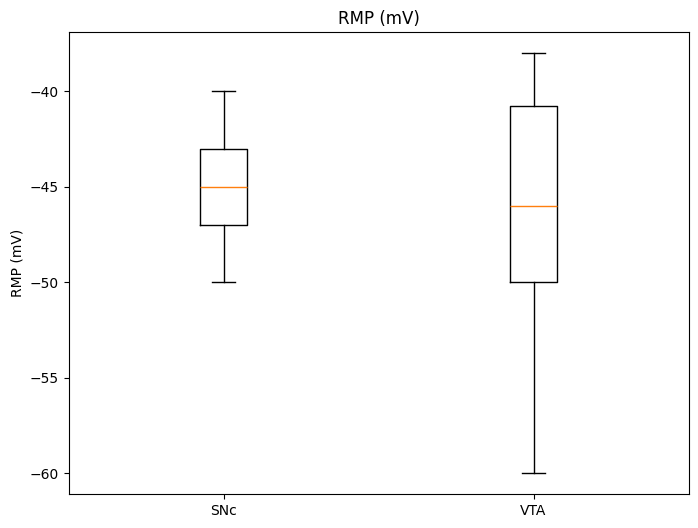

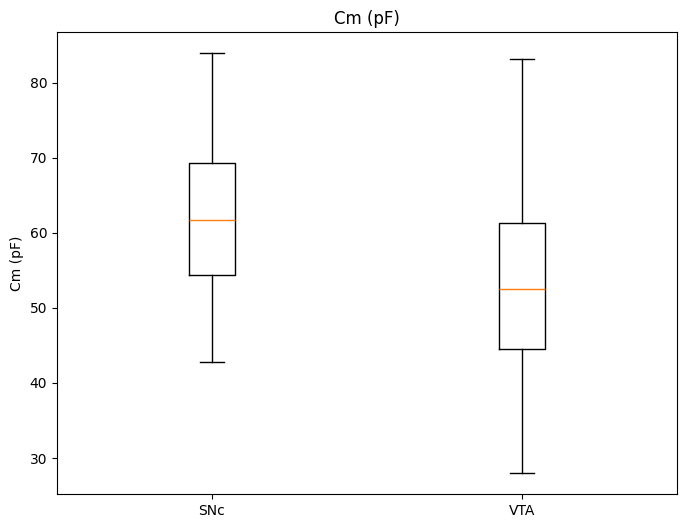

/opt/anaconda3/envs/allen/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 120744 (\N{MATHEMATICAL SANS-SERIF BOLD ITALIC CAPITAL OMEGA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


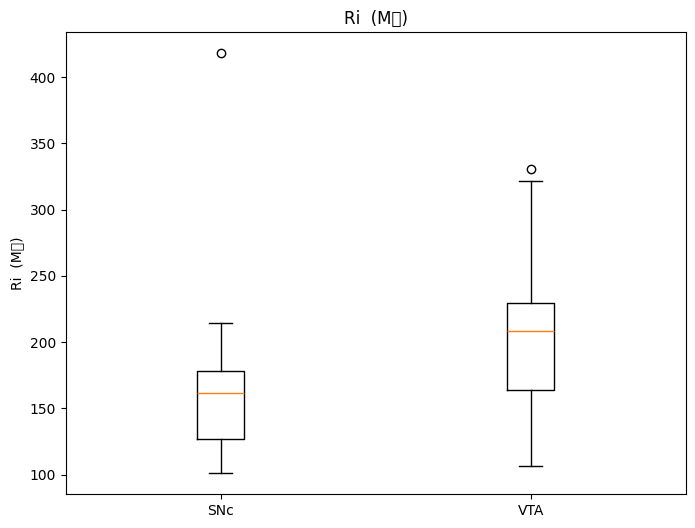

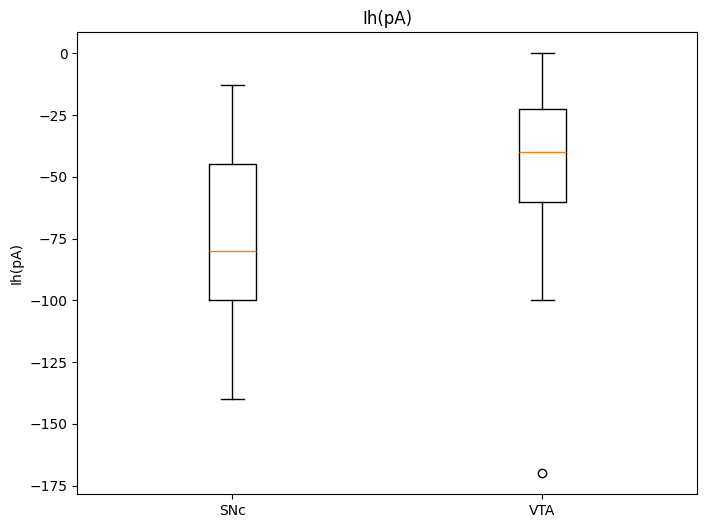

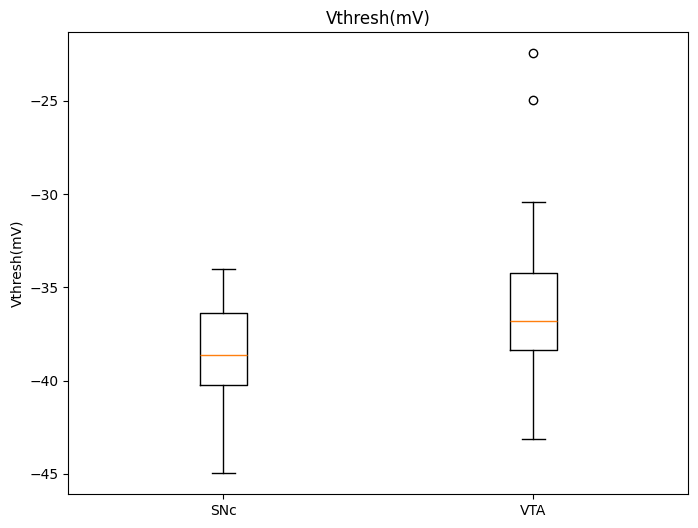

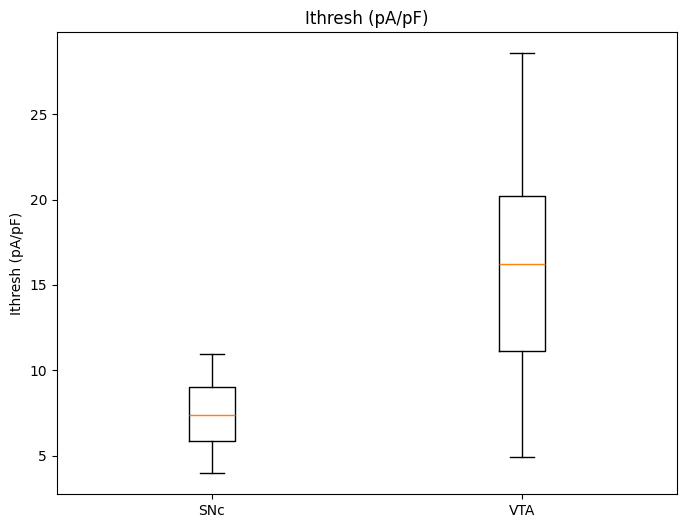

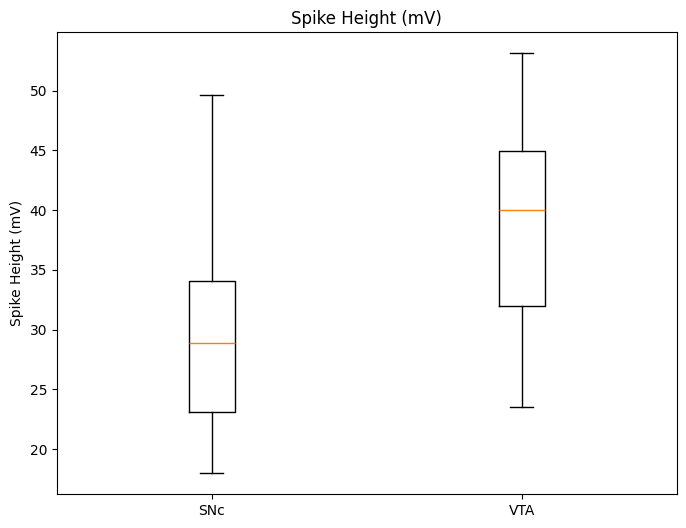

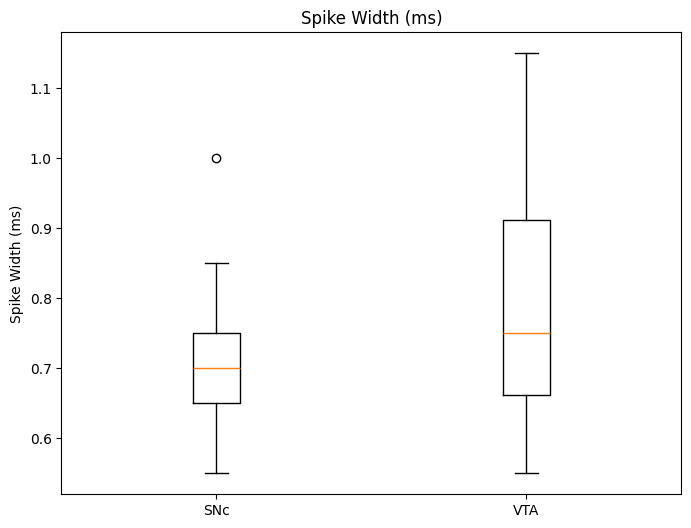

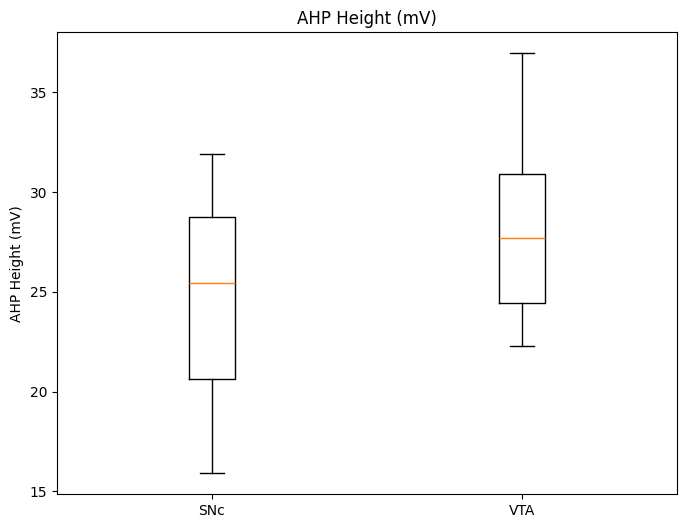

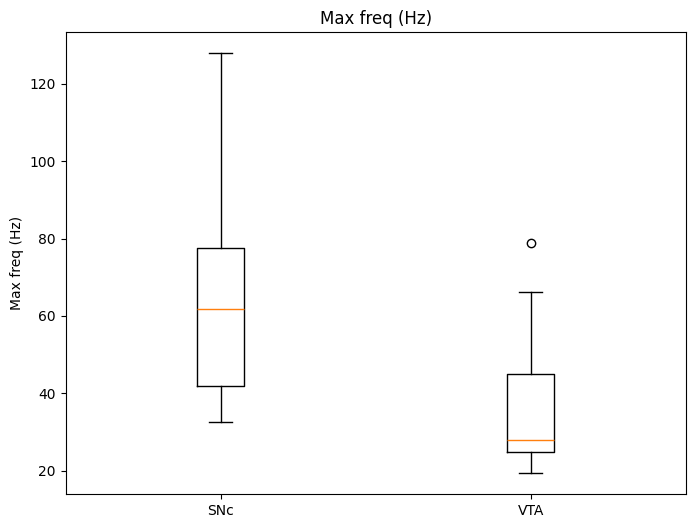

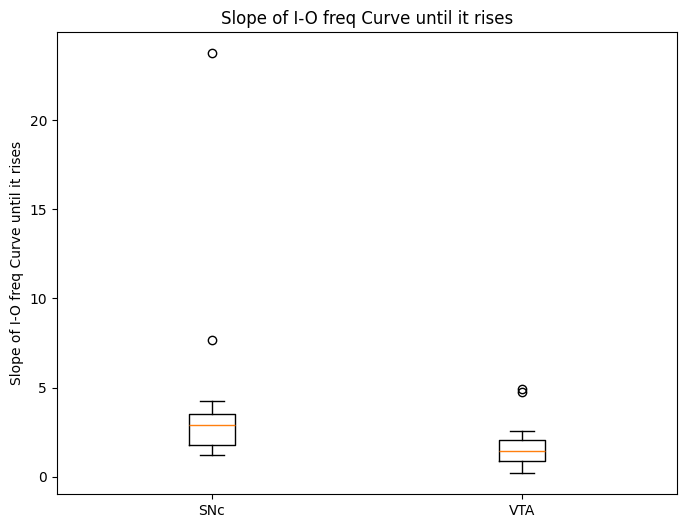

In [39]:
features = [
    'RMP (mV)', 'Cm (pF)', 'Ri  (M𝞨)', 'Ih(pA)',
    'Vthresh(mV)', 'Ithresh (pA/pF)', 'Spike Height (mV)', 
    'Spike Width (ms)', 'AHP Height (mV)', 'Max freq (Hz)', 
    'Slope of I-O freq Curve until it rises'
]

for feature in features:
    plt.figure(figsize=(8, 6))
    plt.boxplot([
        snc_df_PD[feature].dropna(),
        vta_df_PD[feature].dropna()
    ])
    plt.xticks([1, 2], ['SNc', 'VTA'])
    plt.title(feature)
    plt.ylabel(feature)
    plt.show()

In [ ]:
stats_results = []

def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

rows = []

for feature in features:
    snc = snc_df_PD[feature].dropna()
    vta = vta_df_PD[feature].dropna()

    tstat, pval = stats.ttest_ind(snc, vta, equal_var=False)
    
    rows.append({
        "Feature": feature,
        "SNc (mean ± SD)": f"{snc.mean():.2f} ± {snc.std():.2f}",
        "VTA (mean ± SD)": f"{vta.mean():.2f} ± {vta.std():.2f}",
        "t-statistic": f"{tstat:.2f}",
        "p-value": f"{pval:.4f}",
        "Significance": significance_stars(pval)
    })

stats_table = pd.DataFrame(rows)
stats_table.sort_values("p-value", inplace=True)

def highlight_sig(val):
    color = 'background-color: #ffdddd' if val != 'ns' else ''
    return color

stats_table.style.applymap(highlight_sig, subset=['Significance'])


/var/folders/qn/hthllg0d06xgnn01y522tbzc0000gn/T/ipykernel_53207/1576044926.py:19: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  tstat, pval = stats.ttest_ind(snc, vta, equal_var=False)


,Feature,SNc (mean ± SD),VTA (mean ± SD),t-statistic,p-value,Significance
5,Ithresh (pA/pF),7.59 ± 2.21,16.12 ± 6.92,-4.38,0.0005,***
9,Max freq (Hz),66.85 ± 30.42,37.42 ± 18.63,3.00,0.0071,**
6,Spike Height (mV),29.70 ± 10.27,38.84 ± 9.47,-2.40,0.0245,*
4,Vthresh(mV),-38.71 ± 3.36,-35.25 ± 5.73,-1.93,0.0669,ns
8,AHP Height (mV),24.78 ± 5.26,28.10 ± 4.59,-1.74,0.0940,ns
10,Slope of I-O freq Curve until it rises,4.61 ± 5.99,1.82 ± 1.43,1.64,0.1255,ns
1,Cm (pF),61.78 ± 12.24,53.56 ± 15.89,1.51,0.1431,ns
3,Ih(pA),-71.08 ± 36.23,-48.71 ± 43.39,-1.46,0.1576,ns
7,Spike Width (ms),0.72 ± 0.12,0.80 ± 0.18,-1.37,0.1847,ns
2,Ri (M𝞨),173.34 ± 79.74,209.27 ± 69.25,-1.25,0.2249,ns


Describe your data wrangling steps here.

## Data Analysis & Results

Include cells that describe the steps in your data analysis.


Mean expression per probe:
D38101_s_at: VTA=25.235, SNc=30.647, t=-0.591, p=0.5645
M57682_at: VTA=7.339, SNc=11.329, t=-1.878, p=0.0844
M99221_s_at: VTA=9.541, SNc=5.805, t=0.973, p=0.3580
U14005exon#1_s_at: VTA=145.505, SNc=158.880, t=-0.355, p=0.7282
U31772_s_at: VTA=3.995, SNc=3.036, t=1.223, p=0.2434
U49126_s_at: VTA=6.864, SNc=5.934, t=0.338, p=0.7426

Average across all CACNA1D probes: VTA=33.080, SNc=35.938
Log2 fold change (VTA vs SNc): -0.120


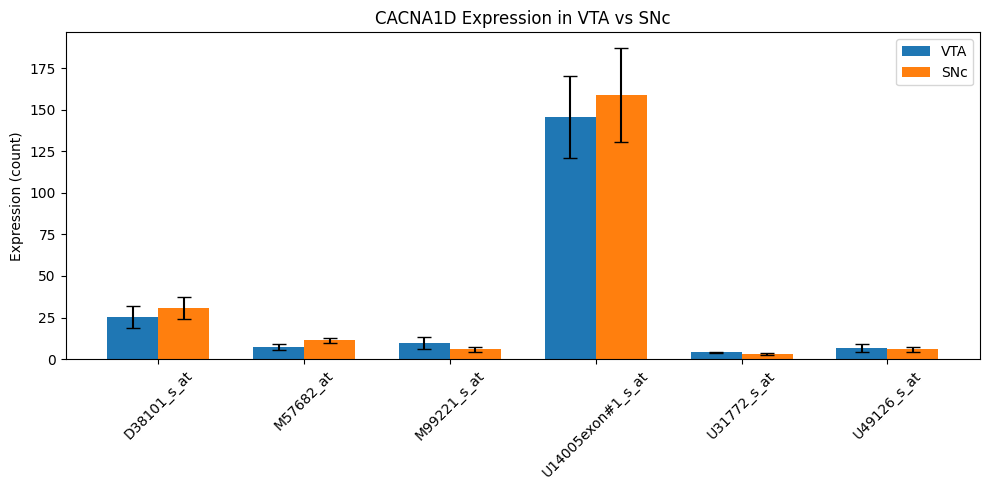

In [ ]:
# Gene expression probes can yield different results due to differences in splicing variants, so we compute the means to compare
print("\nMean expression per probe:")
for probe in df_cacna1d['ID_REF']:
    vta_mean = df_cacna1d.loc[df_cacna1d['ID_REF']==probe, vta_samples].astype(float).mean(axis=1).values[0]
    snc_mean = df_cacna1d.loc[df_cacna1d['ID_REF']==probe, snc_samples].astype(float).mean(axis=1).values[0]
    t_stat, p_val = ttest_ind(df_cacna1d.loc[df_cacna1d['ID_REF']==probe, vta_samples].astype(float).values.flatten(),
                              df_cacna1d.loc[df_cacna1d['ID_REF']==probe, snc_samples].astype(float).values.flatten(),
                              equal_var=False)
    print(f"{probe}: VTA={vta_mean:.3f}, SNc={snc_mean:.3f}, t={t_stat:.3f}, p={p_val:.4f}")

# Compute overall averages and log2 fold change, a change in expression between two samples. A log2 fold change of 1 means the expression is doubled in VTA compared to SNc, while -1 means it's halved.
vta_avg = df_cacna1d[vta_samples].astype(float).mean(axis=1).mean()
snc_avg = df_cacna1d[snc_samples].astype(float).mean(axis=1).mean()
log2_fc = np.log2(vta_avg / snc_avg)

print(f"\nAverage across all CACNA1D probes: VTA={vta_avg:.3f}, SNc={snc_avg:.3f}")
print(f"Log2 fold change (VTA vs SNc): {log2_fc:.3f}")

# Compute means and SEMs
means = []
sems = []
probes = df_cacna1d['ID_REF'].tolist()
for probe in probes:
    vta_vals = df_cacna1d.loc[df_cacna1d['ID_REF']==probe, vta_samples].astype(float).values.flatten()
    snc_vals = df_cacna1d.loc[df_cacna1d['ID_REF']==probe, snc_samples].astype(float).values.flatten()
    means.append([vta_vals.mean(), snc_vals.mean()])
    sems.append([vta_vals.std(ddof=1)/np.sqrt(len(vta_vals)), snc_vals.std(ddof=1)/np.sqrt(len(snc_vals))])

means = np.array(means)
sems = np.array(sems)

# Plot
x = np.arange(len(probes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x - width/2, means[:,0], width, yerr=sems[:,0], capsize=5, label='VTA')
ax.bar(x + width/2, means[:,1], width, yerr=sems[:,1], capsize=5, label='SNc')

ax.set_xticks(x)
ax.set_xticklabels(probes, rotation=45)
ax.set_ylabel("Expression (count)")
ax.set_title("CACNA1D Expression in VTA vs SNc")
ax.legend()
plt.tight_layout()
plt.show()


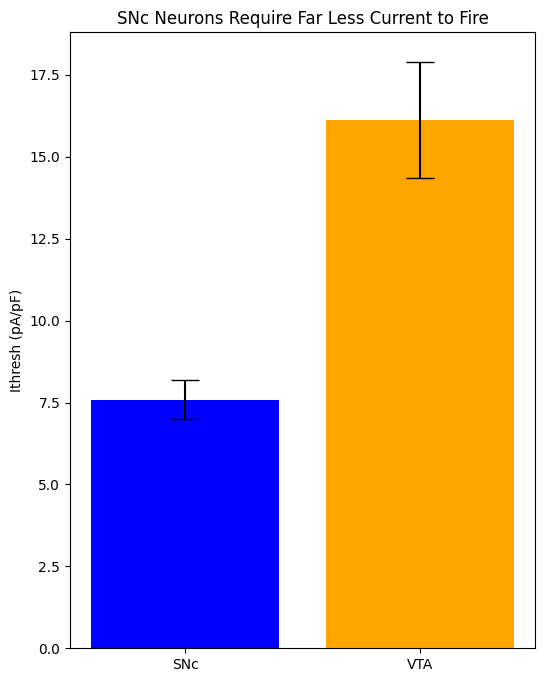

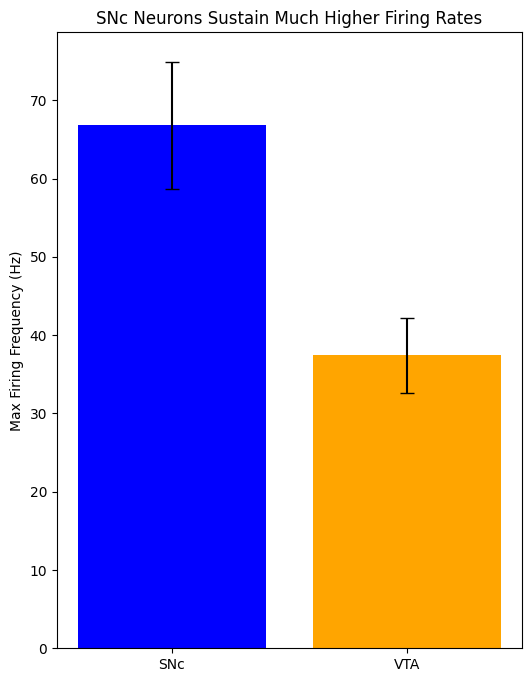

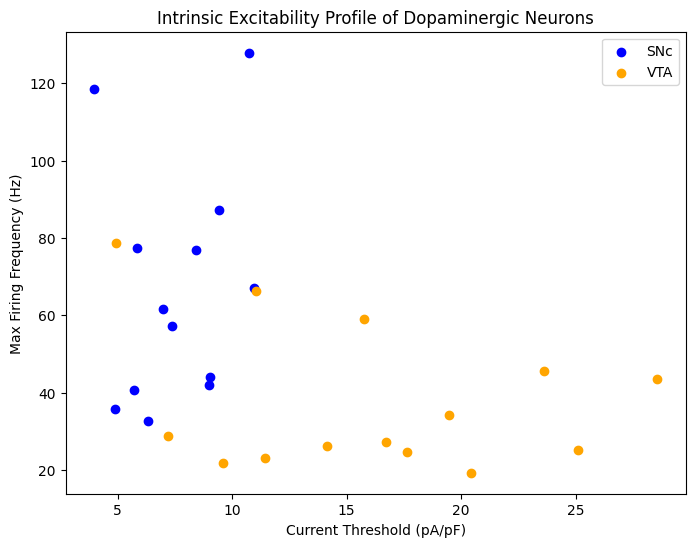

In [35]:
### Figures
# Threshold differences between SNc and VTA neurons, which may contribute to the selective vulnerability of SNc neurons in Parkinson's disease. We will create a bar plot comparing the mean Ithresh (pA/pF) between SNc and VTA neurons, with error bars representing the standard error of the mean. 
def mean_sem(x):
    return np.mean(x), np.std(x)/np.sqrt(len(x))

snc = snc_df_PD['Ithresh (pA/pF)'].dropna()
vta = vta_df_PD['Ithresh (pA/pF)'].dropna()

means = [mean_sem(snc)[0], mean_sem(vta)[0]]
sems = [mean_sem(snc)[1], mean_sem(vta)[1]]

plt.figure(figsize=(6, 8))
plt.bar(['SNc', 'VTA'], means, yerr=sems, capsize=10, color=['blue', 'orange'])
plt.ylabel('Ithresh (pA/pF)')
plt.title('SNc Neurons Require Far Less Current to Fire')
plt.show()

snc = snc_df_PD['Max freq (Hz)'].dropna()
vta = vta_df_PD['Max freq (Hz)'].dropna()

means = [mean_sem(snc)[0], mean_sem(vta)[0]]
sems = [mean_sem(snc)[1], mean_sem(vta)[1]]

plt.figure(figsize=(6, 8))
plt.bar(['SNc', 'VTA'], means, yerr=sems, capsize=5, color=['blue', 'orange'])
plt.ylabel('Max Firing Frequency (Hz)')
plt.title('SNc Neurons Sustain Much Higher Firing Rates')
plt.show()

plt.figure(figsize=(8, 6))

plt.scatter(
    snc_df_PD['Ithresh (pA/pF)'],
    snc_df_PD['Max freq (Hz)'],
    label='SNc',
    color='blue'
)

plt.scatter(
    vta_df_PD['Ithresh (pA/pF)'],
    vta_df_PD['Max freq (Hz)'],
    label='VTA',
    color='orange'
)

plt.xlabel('Current Threshold (pA/pF)')
plt.ylabel('Max Firing Frequency (Hz)')
plt.title('Intrinsic Excitability Profile of Dopaminergic Neurons')
plt.legend()
plt.show()

SNc dopaminergic neurons exhibited significantly lower current thresholds and higher maximum firing frequencies compared to VTA neurons, indicating substantially greater intrinsic excitability. Combined with their smaller spike amplitudes and previously observed higher CACNA1D expression, these results support the hypothesis that SNc neurons experience greater calcium influx and metabolic stress during normal firing, providing a mechanistic explanation for their selective vulnerability in Parkinson’s disease

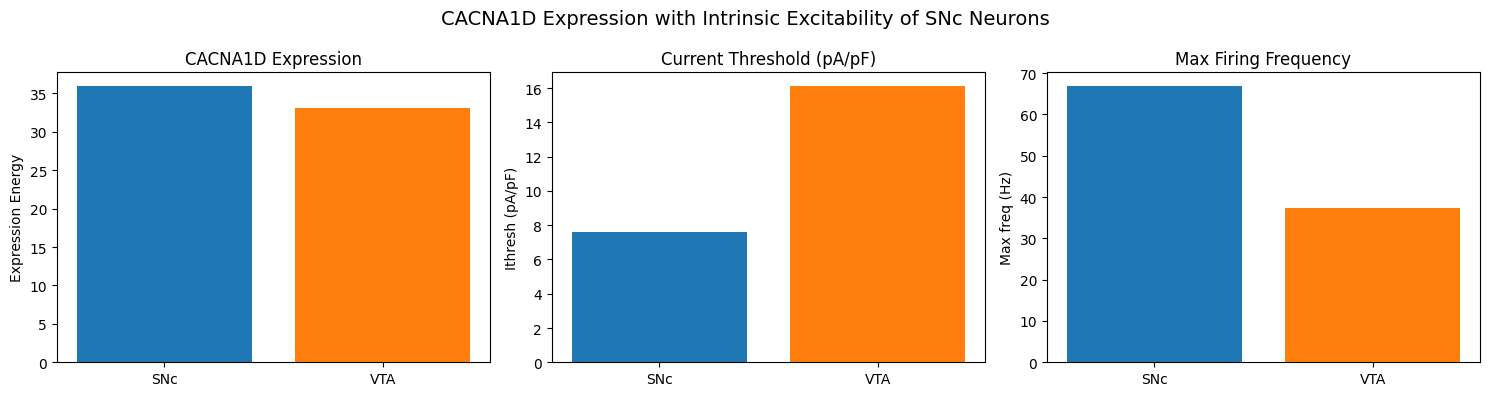

In [37]:
cacna1d_snc = snc_avg
cacna1d_vta = vta_avg

ithresh_snc = snc_df_PD['Ithresh (pA/pF)'].mean()
ithresh_vta = vta_df_PD['Ithresh (pA/pF)'].mean()

freq_snc = snc_df_PD['Max freq (Hz)'].mean()
freq_vta = vta_df_PD['Max freq (Hz)'].mean()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
snc_color = 'tab:blue'
vta_color = 'tab:orange'

# Panel 1 shows CACNA1D expression
axes[0].bar(['SNc', 'VTA'], [cacna1d_snc, cacna1d_vta], color=[snc_color, vta_color])
axes[0].set_title('CACNA1D Expression')
axes[0].set_ylabel('Expression Energy')

# Panel 2 shows Current Threshold
axes[1].bar(['SNc', 'VTA'], [ithresh_snc, ithresh_vta], color=[snc_color, vta_color])
axes[1].set_title('Current Threshold (pA/pF)')
axes[1].set_ylabel('Ithresh (pA/pF)')

# Panel 3 shows Max Firing Frequency
axes[2].bar(['SNc', 'VTA'], [freq_snc, freq_vta], color=[snc_color, vta_color])
axes[2].set_title('Max Firing Frequency')
axes[2].set_ylabel('Max freq (Hz)')

plt.suptitle('CACNA1D Expression with Intrinsic Excitability of SNc Neurons', fontsize=14)
plt.tight_layout()
plt.show()

Although CACNA1D expression was slightly higher in SNc dopaminergic neurons, this difference was not statistically significant. However, SNc neurons displayed dramatically lower current thresholds and higher maximum firing frequencies. This suggests that selective vultnerability in Parkinson's disease may arise not simply from greater calcium channel expression, but from how SNc neurons functionally rely on calcium-mediated pacemaking for their intrinsic excitability. 

## Conclusion & Discussion

*Fill in your discussion information here*

CACNA1D expression is largely similar between SNc and VTA dopaminergic neurons, with no statistically significant differences at the mRNA level. Thus, mRNA abundance differences likely do not explain SNc selective vulnerability in Parkinson’s disease. That is to say, expression level alone cannot explain selective SNc vulnerability. If CACNA1D levels are similar, then the difference must be in how the neurons use the channel. Thus, our key insight analyzes CaV1.3 as a pacemaker channel. If SNc neurons rely more heavily on this rhythmic generation of action potentials, they will experience greater chronic calcium load even at the same expression level. Here, significant differences in current thresholds and maximum firing frequencies indicates an underlying mechanism implicating SNc dopaminergic neurons in Parkinson's disease, rather than a mere correlation. 

Based on the current literature, PD vulnerability is differential across the two midbrain dopaminergic neurons of interest to this project. Specifically, SNc neurons are in fact highly vulnerable to PD compared to VTA neurons. Over the course of this project, we extracted the CACNA1D gene expression data for dopaminergic neurons in the Substantia Nigra pars compacta (SNc) and the Ventral Tegmental Area (VTA) from the Gene Expression Omnibus and integrated it with their respective electrophysiological data from the University of Cambridge Apollo dataset from Lau, 2024. Our findings indicate that this vulnerability is functional rather than transcriptional, seeing as the gene expression data for specific calcium channels is similar across the two regions but their electrophysiological data demonstrates key differences. SNc neurons exhibit higher excitability that enable greater CaV1.3-mediated calcium entry over time. This functional difference may underlie the selective vulnerability of SNc neurons in Parkinson's disease. 